In [1]:
%matplotlib inline

seed_value = 100
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

# Data uploading

In [2]:
AIRPORT_ICAO = "ESGG"
#AIRPORT_ICAO = "ESSA"

RT1 = True
remove_outliers = False

#runway = "21"
#cluster = 2

DATA_DIR = os.path.join("..", "..")
DATA_DIR = os.path.join(DATA_DIR, "data")
DATA_DIR = os.path.join(DATA_DIR, "Regression")

# WIF
if RT1:
    filename = AIRPORT_ICAO + "_metrics_WIF_fuel_by_hour_RT1.csv"
else:
    filename = AIRPORT_ICAO + "_metrics_WIF_fuel_by_hour_RT2.csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_WIF_fuel_by_hour_df = pd.read_csv(full_filename, sep=' ')

print(metrics_WIF_fuel_by_hour_df.head(1))

# TIF
if RT1:
    filename = AIRPORT_ICAO + "_metrics_TIF_fuel_by_hour_RT1.csv"
else:
    filename = AIRPORT_ICAO + "_metrics_TIF_fuel_by_hour_RT2.csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_TIF_fuel_by_hour_df = pd.read_csv(full_filename, sep=' ')

print(metrics_TIF_fuel_by_hour_df.head(1))

     date  hour  numberOfFlights  addFuelMean  addFuelMedian  WIF
0  191001     1                1       86.762         86.762    4
     date  hour  numberOfFlights  addFuelMean  addFuelMedian  TIF
0  191001     5                1       -1.776         -1.776    1


# Average Additiona Fuel (RT1)

## Medians of Average Additional Fuel in TMA vs TIF

       date  hour  numberOfFlights  addFuelMean  addFuelMedian
TIF                                                           
1    191001     5                1       -1.776         -1.776
251
99
89
60
45
34
2
2
1
                            OLS Regression Results                            
Dep. Variable:          addFuelMedian   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.091
Method:                 Least Squares   F-statistic:                    0.3335
Date:                Fri, 25 Mar 2022   Prob (F-statistic):              0.582
Time:                        13:18:43   Log-Likelihood:                -29.989
No. Observations:                   9   AIC:                             63.98
Df Residuals:                       7   BIC:                             64.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                      

C:\Users\anale19\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


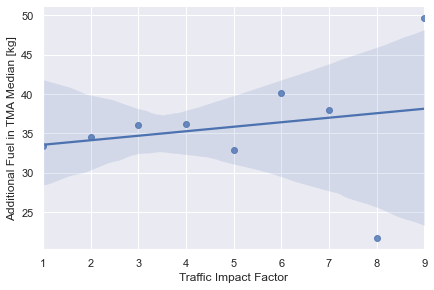

In [3]:
df = metrics_TIF_fuel_by_hour_df.copy()

df = df[df['numberOfFlights']>0]

if remove_outliers:
    p1 = df["addFuelMean"].quantile(0.05)
    p2 = df["addFuelMean"].quantile(0.95)
    df = df.loc[(df['addFuelMean'] > p1) & (df['addFuelMean'] < p2) ]

df.set_index(['TIF'], inplace=True)
df.sort_index(inplace=True)

print(df.head(1))

median_df = pd.DataFrame(columns=['TIF', 'addFuelMedian'])

for idx, group in df.groupby(level='TIF'):
    
    idx_df = group['addFuelMean']
    print(len(idx_df))
    
    idx_median = np.median(idx_df)
    median_df = median_df.append({'TIF': idx, 'addFuelMedian': idx_median}, ignore_index=True)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='TIF',y='addFuelMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Traffic Impact Factor')
#plt.ylabel('Additional Distance in TMA Median [NM]')
plt.ylabel('Additional Fuel in TMA Median [kg]')

#statsmodel:
X_df = median_df[['TIF']]
y_df = median_df[['addFuelMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary())
# RT1
# with outliers - ESGG: 0.05, ESSA: 0.88
# without outliers - ESGG: 0.05, ESSA: 0.84

# RT2 (only ESGG April 2020 now)
# with outliers - ESGG: 0.05, ESSA: 
# without outliers - ESGG: 0.05, ESSA: 

## Medians of Average Additional Fuel in TMA vs WIF

                            OLS Regression Results                            
Dep. Variable:          addFuelMedian   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     5.370
Date:                Fri, 25 Mar 2022   Prob (F-statistic):             0.0536
Time:                        13:18:44   Log-Likelihood:                -42.222
No. Observations:                   9   AIC:                             88.44
Df Residuals:                       7   BIC:                             88.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3827     21.725      0.064      0.9

C:\Users\anale19\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


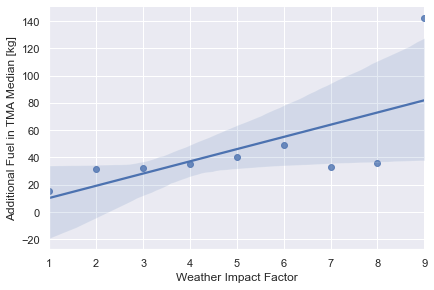

In [4]:
df = metrics_WIF_fuel_by_hour_df.copy()
df.dropna(inplace=True)
df = df[df['numberOfFlights']>0]

if remove_outliers:
    p1 = df["addFuelMean"].quantile(0.05)
    p2 = df["addFuelMean"].quantile(0.95)
    df = df.loc[(df['addFuelMean'] > p1) & (df['addFuelMean'] < p2) ]

df.set_index(['WIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['WIF', 'addFuelMedian'])

for idx, group in df.groupby(level='WIF'):
    
    idx_df = group['addFuelMean']

    idx_median = np.median(idx_df)
            
    median_df = median_df.append({'WIF': idx, 'addFuelMedian': idx_median}, ignore_index=True)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='WIF',y='addFuelMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Weather Impact Factor')
plt.ylabel('Additional Fuel in TMA Median [kg]')

#statsmodel:
X_df = median_df[['WIF']]
y_df = median_df[['addFuelMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary()) 
# RT1
# with outliers - ESGG: 0.43 ESSA: 0.41
# without outliers - ESGG: 0.54 ESSA: 0.05

# RT2
# with outliers - ESGG: 0.35 ESSA: 
# without outliers - ESGG: 0.46 ESSA: 